# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tslearn.clustering import TimeSeriesKMeans

from sklearn.metrics import silhouette_score

from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

# Loading data

In [3]:
path_to_data = './../../qualitative_analysis/data/preprocessed_data/ftir_scaled_train.csv'
path_to_description = './../../qualitative_analysis/data/preprocessed_data/ftir_description.csv'

## Scaled spectra

In [4]:
data_scaled = pd.read_csv(path_to_data, index_col=0)

print(data_scaled.shape)
data_scaled.head(3)

(26, 1142)


0            1            2            3            4  \
wavenumber  1900.766600  1899.802230  1898.837870  1897.873500  1896.909130   
1              0.000494     0.000944     0.001362     0.001750     0.002112   
2              0.000210     0.000215     0.000213     0.000205     0.000192   

                      5            6            7            8            9  \
wavenumber  1895.944770  1894.980400  1894.016030  1893.051670  1892.087300   
1              0.002451     0.002770     0.003074     0.003364     0.003646   
2              0.000175     0.000155     0.000132     0.000109     0.000085   

                     10           11           12           13           14  \
wavenumber  1891.122930  1890.158570  1889.194200  1888.229830  1887.265470   
1              0.003921     0.004193     0.004467     0.004744     0.005028   
2              0.000063     0.000042     0.000025     0.000011     0.000003   

                     15           16           17           18          19  \
wavenumber  1886.301100  1885.336730  1884.372370  1883.408000  1882.44364   
1              0.005324     0.005633     0.005960     0.006308     0.00668   
2              0.000000     0.000004     0.000017     0.000039     0.00007   

                     20           21           22           23           24  \
wavenumber  1881.479270  1880.514900  1879.550540  1878.586170  1877.621800   
1              0.007079     0.007509     0.007974     0.008476     0.009019   
2              0.000113     0.000168     0.000236     0.000318     0.000415   

            ...        1117        1118        1119        1120        1121  \
wavenumber  ...  823.569090  822.604720  821.640360  820.675990  819.711620   
1           ...    0.037121    0.035323    0.033560    0.031835    0.030152   
2           ...    0.072690    0.071565    0.070364    0.069083    0.067721   

                  1122        1123        1124        1125        1126  \
wavenumber  818.747260  817.782890  816.818520  815.854160  814.889790   
1             0.028514    0.026926    0.025390    0.023910    0.022491   
2             0.066275    0.064743    0.063123    0.061413    0.059610   

                  1127        1128        1129        1130        1131  \
wavenumber  813.925420  812.961060  811.996690  811.032320  810.067960   
1             0.021135    0.019846    0.018627    0.017483    0.016417   
2             0.057713    0.055719    0.053626    0.051432    0.049135   

                  1132        1133        1134        1135        1136  \
wavenumber  809.103590  808.139230  807.174860  806.210490  805.246130   
1             0.015433    0.014533    0.013723    0.013004    0.012382   
2             0.046732    0.044221    0.041600    0.038868    0.036021   

                  1137        1138        1139        1140        1141  
wavenumber  804.281760  803.317390  802.353030  801.388660  800.424290  
1             0.011859    0.011440    0.011127    0.010924    0.010836  
2             0.033058    0.029976    0.026773    0.023447    0.019997  

[3 rows x 1142 columns]

## Samples description

In [5]:
samples_description = pd.read_csv(path_to_description, index_col=0)

print(samples_description.shape)
samples_description.head(3)

(29, 4)


Description  Type  Class  Label
1                    MFGO, разб. 1:20  $GO$      1  Train
2           HGO, 0.0116 г в 25 мл H2O  $GO$      1  Train
3  GO, RusGraphene, 2 г в 1000 мл H2O  $GO$      1  Train

# Data wrangling

In [6]:
samples_description = (
    samples_description
    .loc[samples_description['Label'] == 'Train']
    .drop(columns=['Label'])
)

samples_description.index = samples_description.index.astype(str)

print(samples_description.shape)
samples_description.head(3)

(25, 3)


Description  Type  Class
1                    MFGO, разб. 1:20  $GO$      1
2           HGO, 0.0116 г в 25 мл H2O  $GO$      1
3  GO, RusGraphene, 2 г в 1000 мл H2O  $GO$      1

In [7]:
wavenumber = data_scaled.iloc[0]
data = data_scaled.iloc[1:, :]

# selecting only go data
go_indexes = samples_description.loc[samples_description['Type'] == '$GO$'].index
go_data = data.loc[go_indexes]

# selecting only go dialysis data
god_indexes = samples_description.loc[samples_description['Type'] == '$GO_{d}$'].index
god_data = data.loc[god_indexes]

# selecting only rgo data
rgo_indexes = samples_description.loc[samples_description['Type'] == '$rGO$'].index
rgo_data = data.loc[rgo_indexes]

In [8]:
type_color_dict = {
    '$GO$': 'RoyalBlue',
    '$rGO$': 'Goldenrod',
    '$GO_{d}$': 'SeaGreen'
}

# Clustering

## Class for clustering

In [9]:
class ClusterStructureAnalysis:
    def __init__(self, metric: str = 'euclidean'):
        self.metric = metric

    def fit_transform_ts_kmeans(self, train_data: pd.DataFrame, n_clusters: int, n_jobs: int = -1, max_iter: int = 100_000, random_state: int = 42):
        estimator = TimeSeriesKMeans(
            n_clusters=n_clusters,
            metric=self.metric,
            n_jobs=n_jobs,
            max_iter=max_iter,
            random_state=random_state
        )
        estimator.fit(train_data)

        self.n_clusters = n_clusters
        self.train_data = train_data
        self.estimator = estimator
        self.inertia = estimator.inertia_
        self.cluster_centers = estimator.cluster_centers_[:, :, 0]

        predictions = pd.DataFrame(estimator.predict(train_data), index=train_data.index, columns=['Prediction'])
        self.predictions = predictions['Prediction']
        self.train_data_predictions = pd.concat([train_data, predictions], axis=1)

    def get_silhouette_score(self) -> float:
        return silhouette_score(self.train_data, self.estimator.labels_) if self.n_clusters >= 2 else None

    def get_inertia(self) -> float:
        return self.inertia

    def get_metric_in_range(self, metric: str = 'silhouette', max_n_clusters: int = None) -> list:
        max_n_clusters = max_n_clusters or (self.train_data.shape[0] // 2)
        n_clusters_arr = range(2, max_n_clusters + 1)

        metric_values = []
        for n_clusters in tqdm(n_clusters_arr, desc=f'Computing {metric} values'):
            self.fit_transform_ts_kmeans(train_data=self.train_data, n_clusters=n_clusters)
            metric_values.append(self.get_silhouette_score() if metric == 'silhouette' else self.get_inertia())

        return metric_values

    def get_metrics_visualization(self, metric: str = 'silhouette', max_n_clusters: int = None, figsize: tuple = (11, 7.5), path_to_save: str = None, dpi: int = 300):
        max_n_clusters = max_n_clusters or (self.train_data.shape[0] - 1)
        n_clusters = list(range(2, max_n_clusters + 1))
        metric_values = self.get_metric_in_range(metric, max_n_clusters)

        sns.set_theme()
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        sns.barplot(
            x=list(range(len(n_clusters))),  # Корректное позиционирование тиков
            y=metric_values, 
            palette='viridis', 
            ax=ax
        )

        ax.set_xlabel('Number of clusters', fontsize=16, labelpad=5)
        ax.set_ylabel('Silhouette score', fontsize=16, labelpad=5)
        ax.grid(True)

        ax.set_xticks(range(len(n_clusters)))
        ax.set_xticklabels(n_clusters, rotation=0, fontsize=12)

        plt.tight_layout()
        if path_to_save:
            plt.savefig(path_to_save, dpi=dpi)
        plt.show()

    def get_spectra_clusters_visualization(self, data: pd.DataFrame, wavenumber: np.ndarray, n_clusters: int, nrows: int, ncols: int,
                                           figsize: tuple = (10, 6), color: str = 'dodgerblue', path_to_save: str = None, dpi: int = 300):
        if n_clusters > nrows * ncols:
            raise ValueError("Too many clusters for given subplot grid. Increase `nrows` or `ncols`.")

        self.fit_transform_ts_kmeans(train_data=data, n_clusters=n_clusters)
        data_with_labels = self.train_data_predictions
        centroids = self.cluster_centers

        fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=dpi)
        axes = axes.flatten()

        for i in range(nrows * ncols):
            if i >= n_clusters:
                axes[i].axis("off")
                continue

            temp_data = data_with_labels.loc[data_with_labels['Prediction'] == i].iloc[:, :-1].to_numpy()
            temp_centroid = centroids[i]

            for spectrum in temp_data:
                axes[i].plot(wavenumber, spectrum, linewidth=2.5, color=color)

            axes[i].plot(wavenumber, temp_centroid, linestyle='--', linewidth=2.5, color='black')

            axes[i].set_xlabel('Wavenumber, cm$^{-1}$', fontsize=12, labelpad=5)
            axes[i].set_ylabel('$A_{n}$', fontsize=12, labelpad=15, rotation=0)
            axes[i].invert_xaxis()

        plt.tight_layout()
        if path_to_save:
            plt.savefig(path_to_save, dpi=dpi)
        plt.show()

## Metric — Euclidean distance

In [10]:
path_to_save = './../results/01a_as_timeseries/euclidean'

### *GO*

Computing silhouette values: 100%|████████████████| 6/6 [00:00<00:00, 42.36it/s]


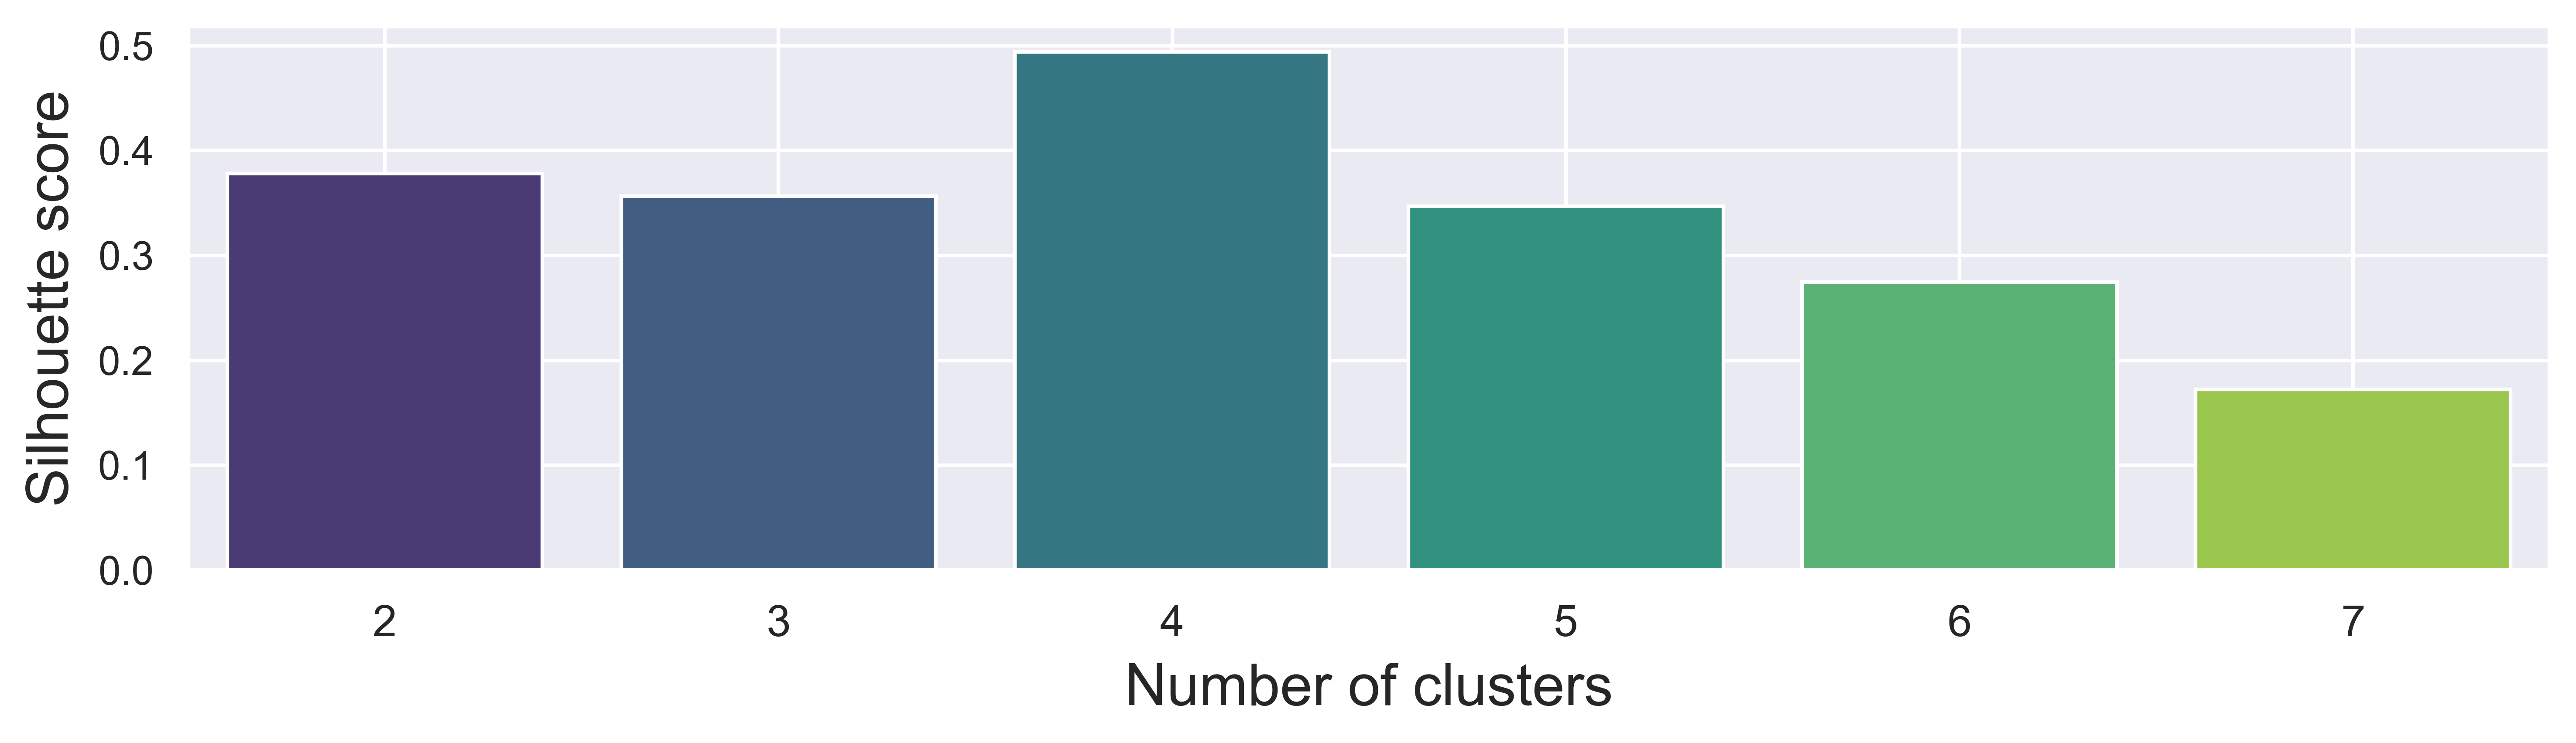

In [11]:
analyzer = ClusterStructureAnalysis(metric='euclidean')
analyzer.fit_transform_ts_kmeans(train_data=go_data, n_clusters=2)

analyzer.get_metrics_visualization(metric='silhouette', figsize=(10, 3), path_to_save=path_to_save + '/go_metrics.png', dpi=600)

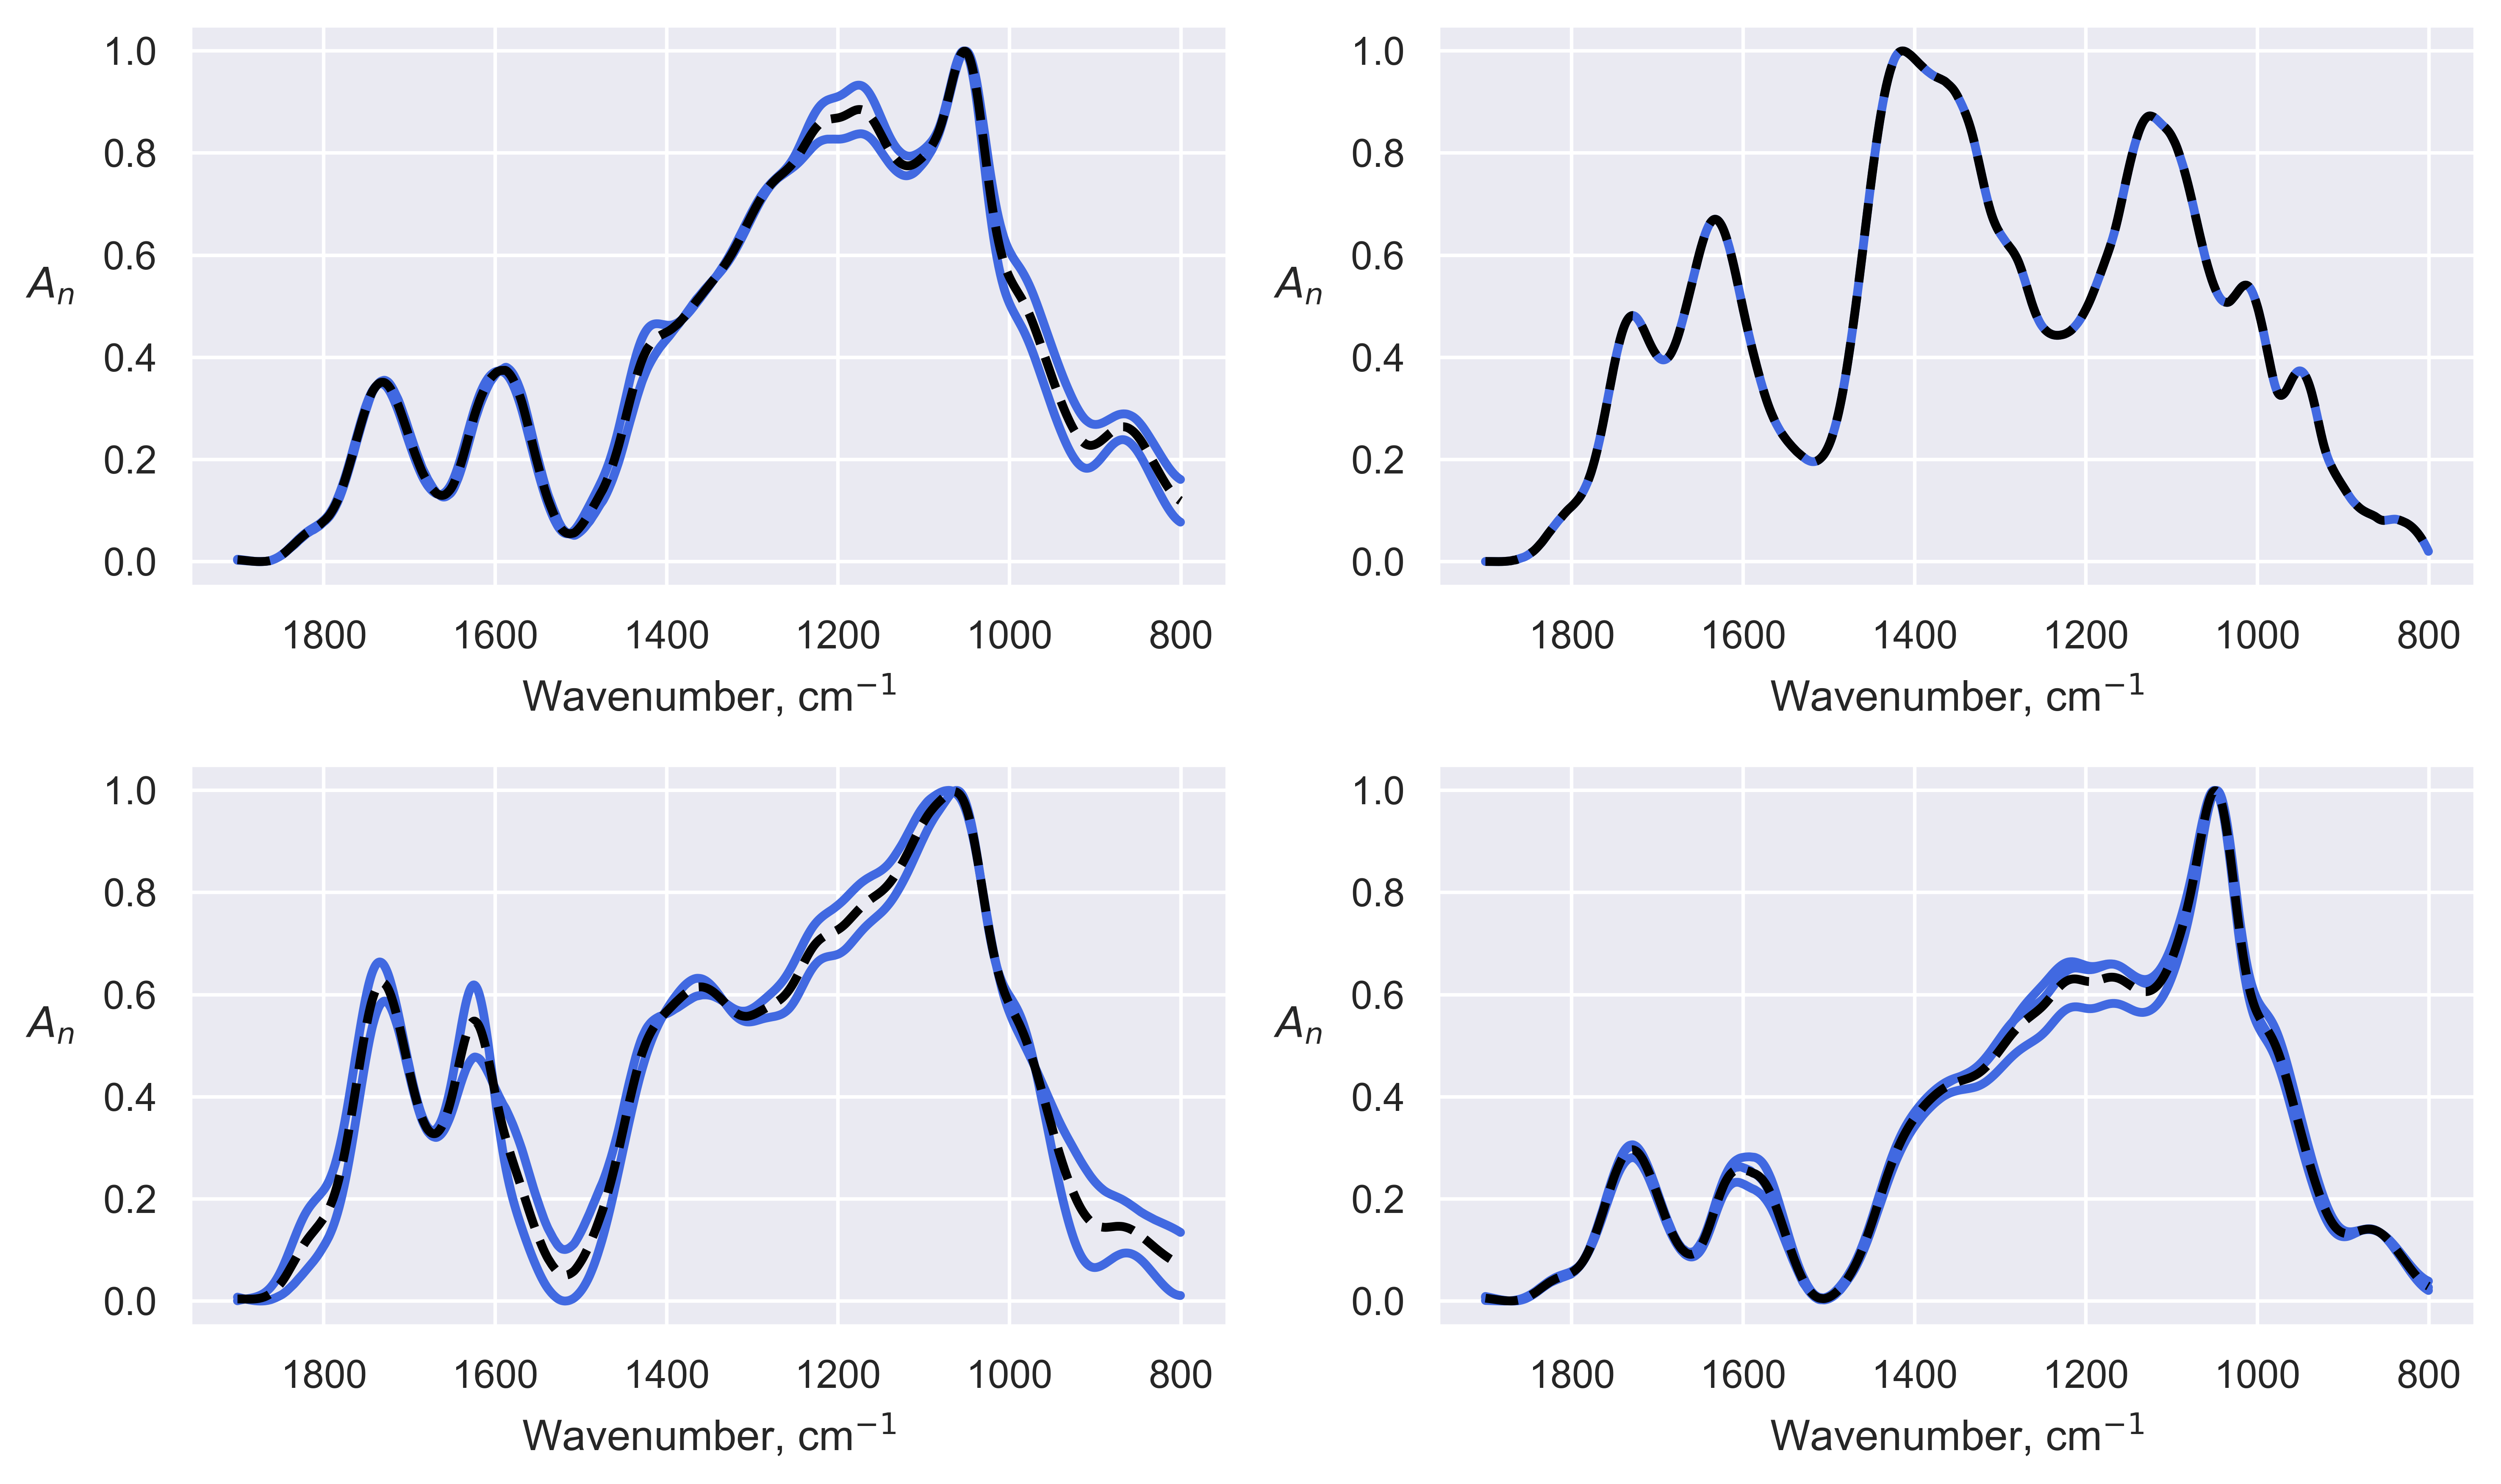

In [12]:
analyzer.get_spectra_clusters_visualization(data=go_data, wavenumber=wavenumber, n_clusters=4,
                                            ncols=2, nrows=2, figsize=(10, 6), color='RoyalBlue',
                                            path_to_save=path_to_save + '/go_clusters.png', dpi=600)

### *rGO*

Computing silhouette values: 100%|████████████████| 1/1 [00:00<00:00, 57.43it/s]


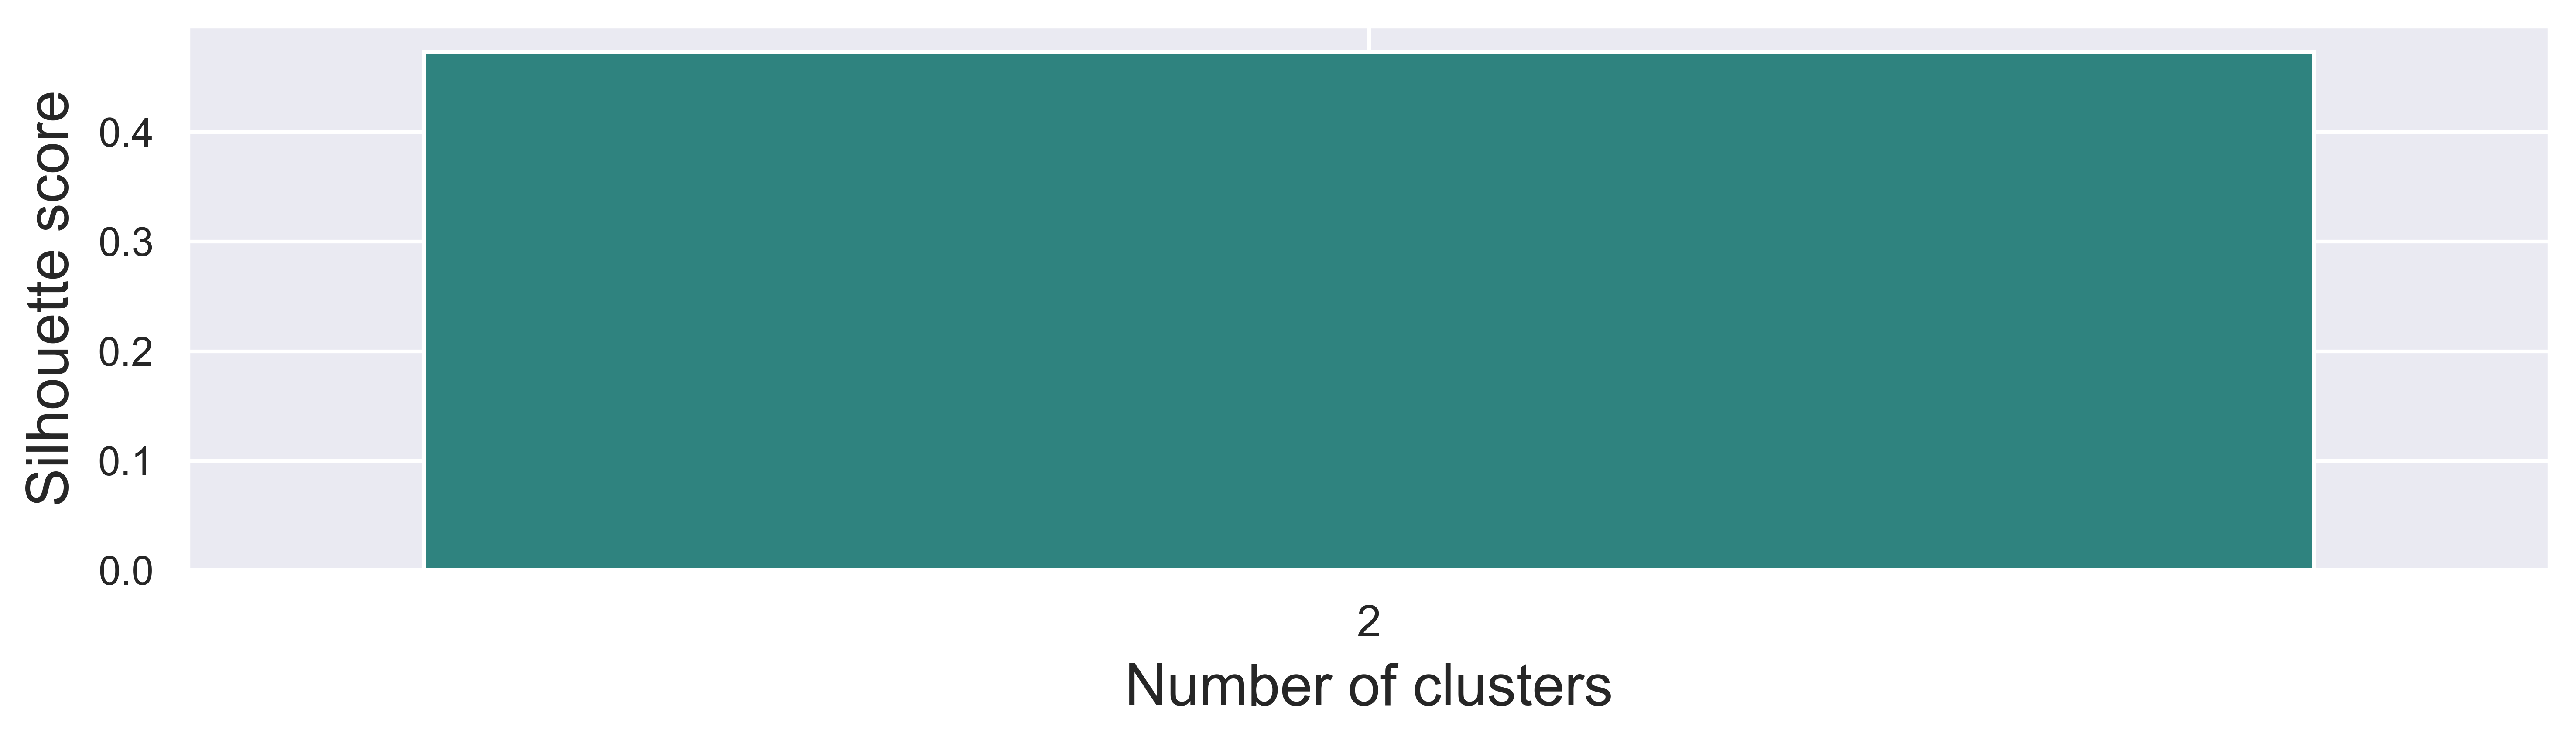

In [13]:
analyzer = ClusterStructureAnalysis(metric='euclidean')
analyzer.fit_transform_ts_kmeans(train_data=rgo_data, n_clusters=2)

analyzer.get_metrics_visualization(metric='silhouette', figsize=(10, 3), path_to_save=path_to_save + '/rgo_metrics.png', dpi=600)

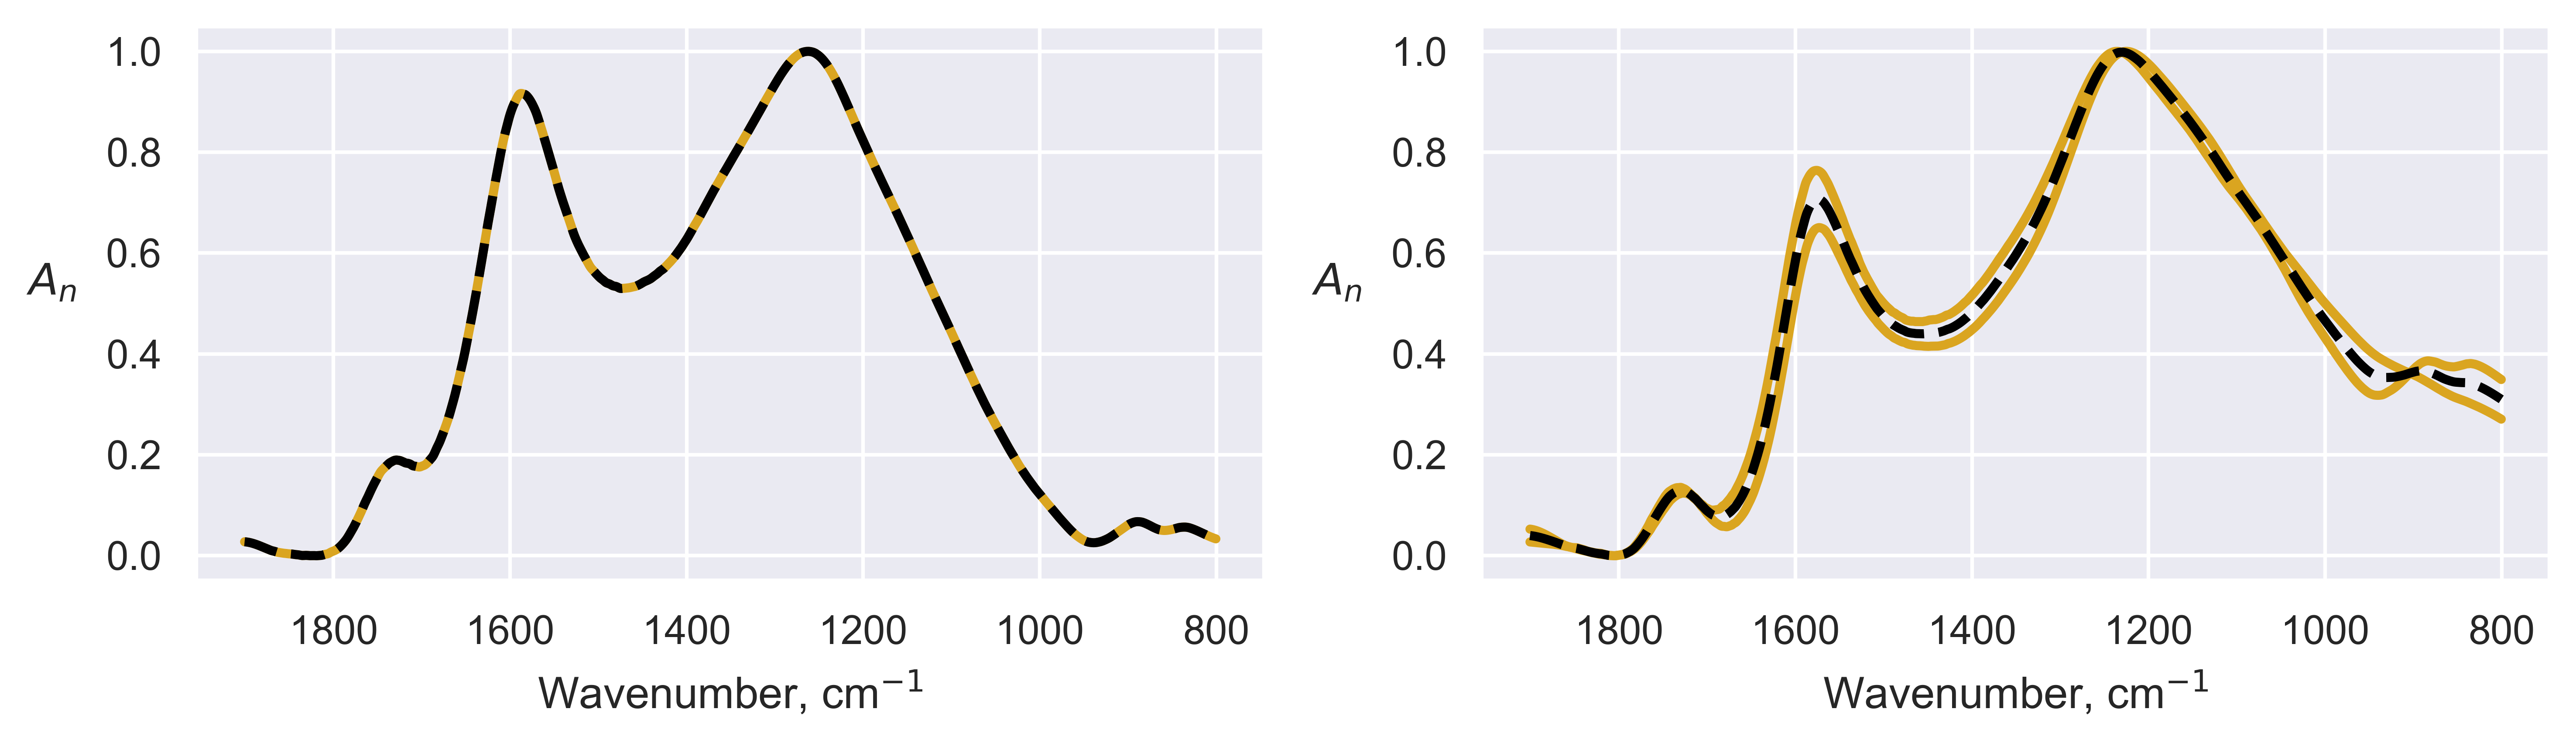

In [14]:
analyzer.get_spectra_clusters_visualization(data=rgo_data, wavenumber=wavenumber, n_clusters=2,
                                            ncols=2, nrows=1, figsize=(10, 3), color='Goldenrod',
                                            path_to_save=path_to_save + '/rgo_clusters.png', dpi=600)

### $GO_{d}$

Computing silhouette values: 100%|██████████████| 12/12 [00:00<00:00, 39.66it/s]


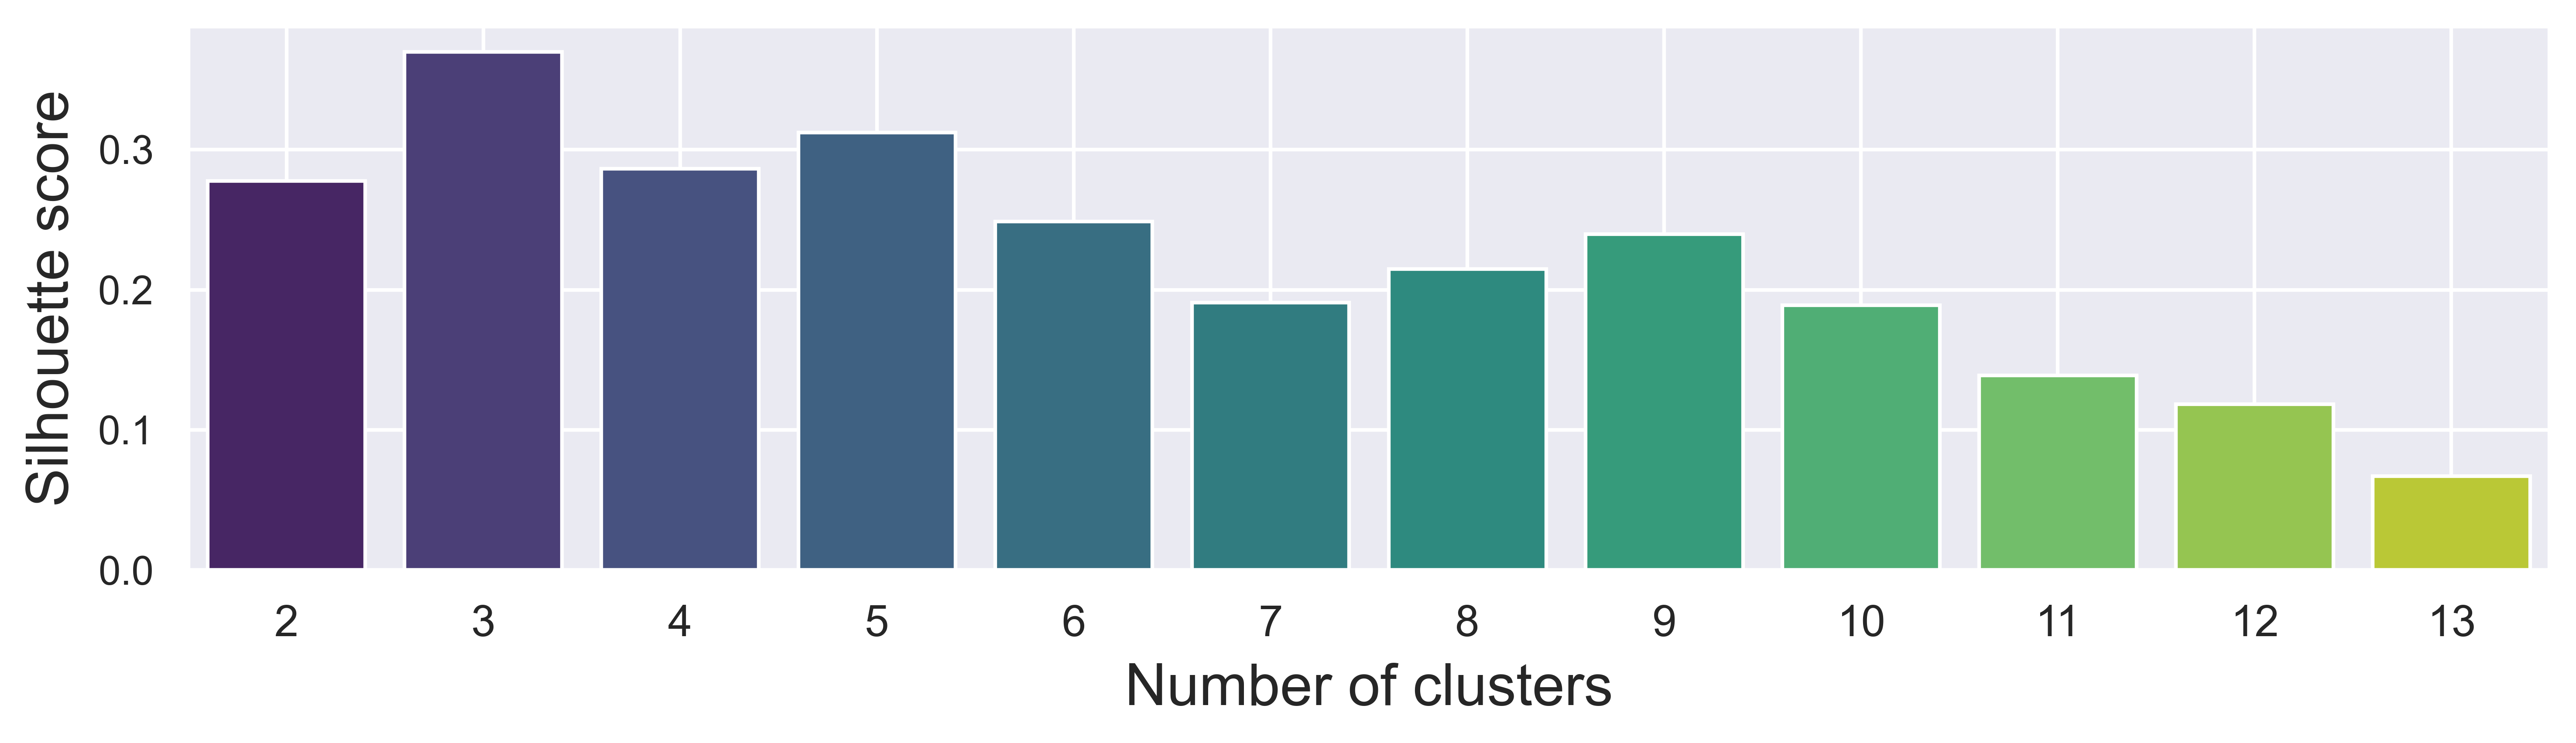

In [15]:
analyzer = ClusterStructureAnalysis(metric='euclidean')
analyzer.fit_transform_ts_kmeans(train_data=god_data, n_clusters=2)

analyzer.get_metrics_visualization(metric='silhouette', figsize=(10, 3), path_to_save=path_to_save + '/god_metrics.png', dpi=600)

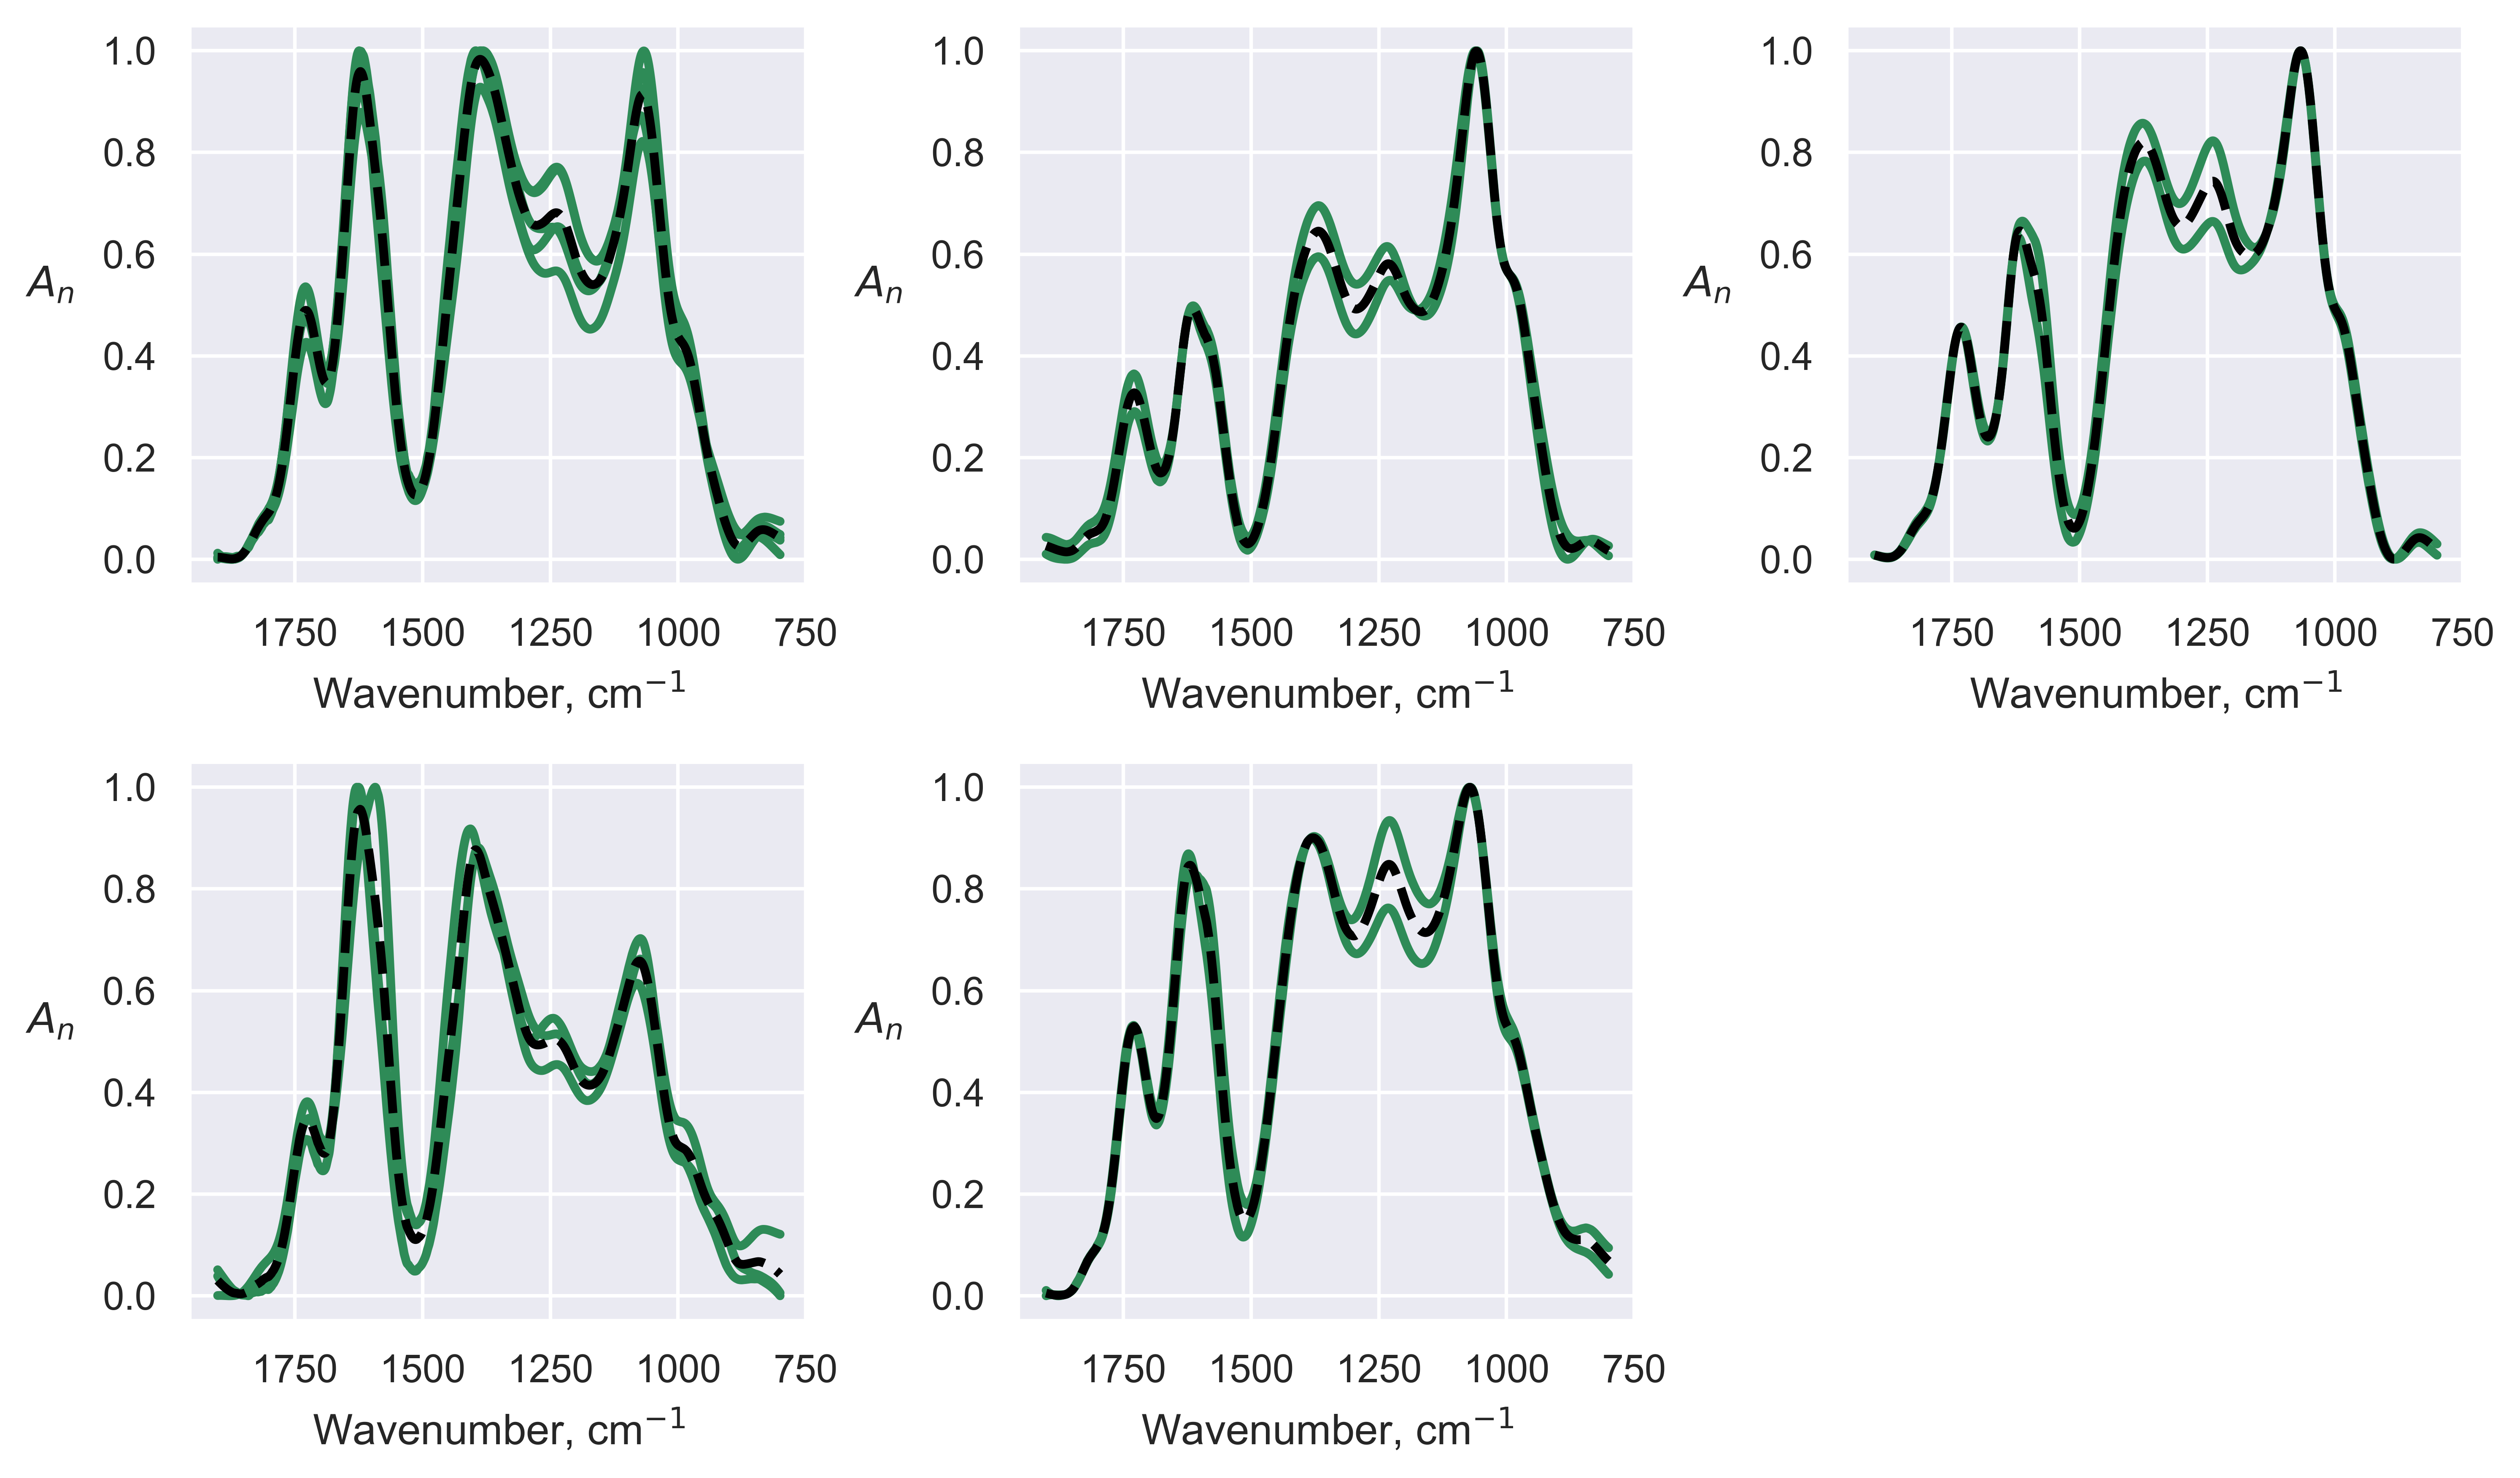

In [16]:
analyzer.get_spectra_clusters_visualization(data=god_data, wavenumber=wavenumber, n_clusters=5,
                                            ncols=3, nrows=2, figsize=(10, 6), color='SeaGreen',
                                            path_to_save=path_to_save + '/god_clusters_5.png', dpi=600
                                           )

## Metric — DTW

In [17]:
path_to_save = './../results/01a_as_timeseries/dtw'

### *GO*

Computing silhouette values: 100%|████████████████| 6/6 [00:26<00:00,  4.50s/it]


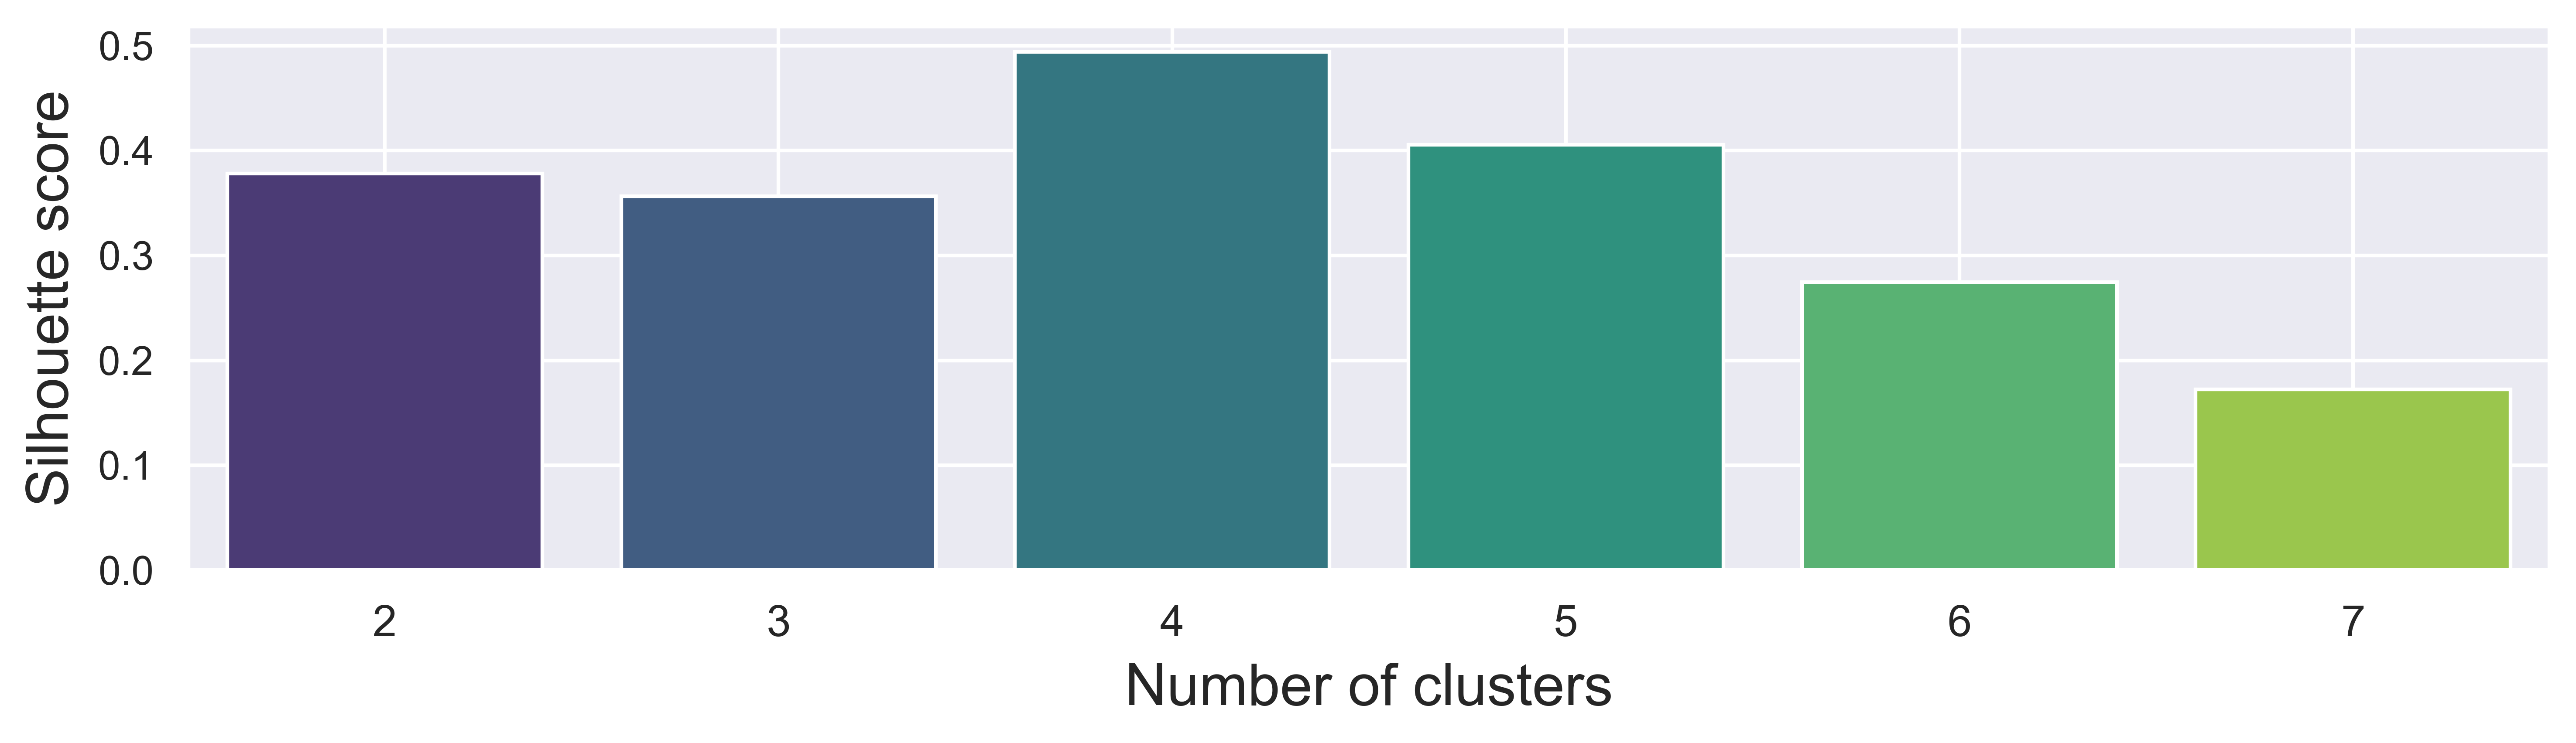

In [18]:
analyzer = ClusterStructureAnalysis(metric='dtw')
analyzer.fit_transform_ts_kmeans(train_data=go_data, n_clusters=2)

analyzer.get_metrics_visualization(metric='silhouette', figsize=(10, 3), path_to_save=path_to_save + '/go_metrics.png', dpi=600)

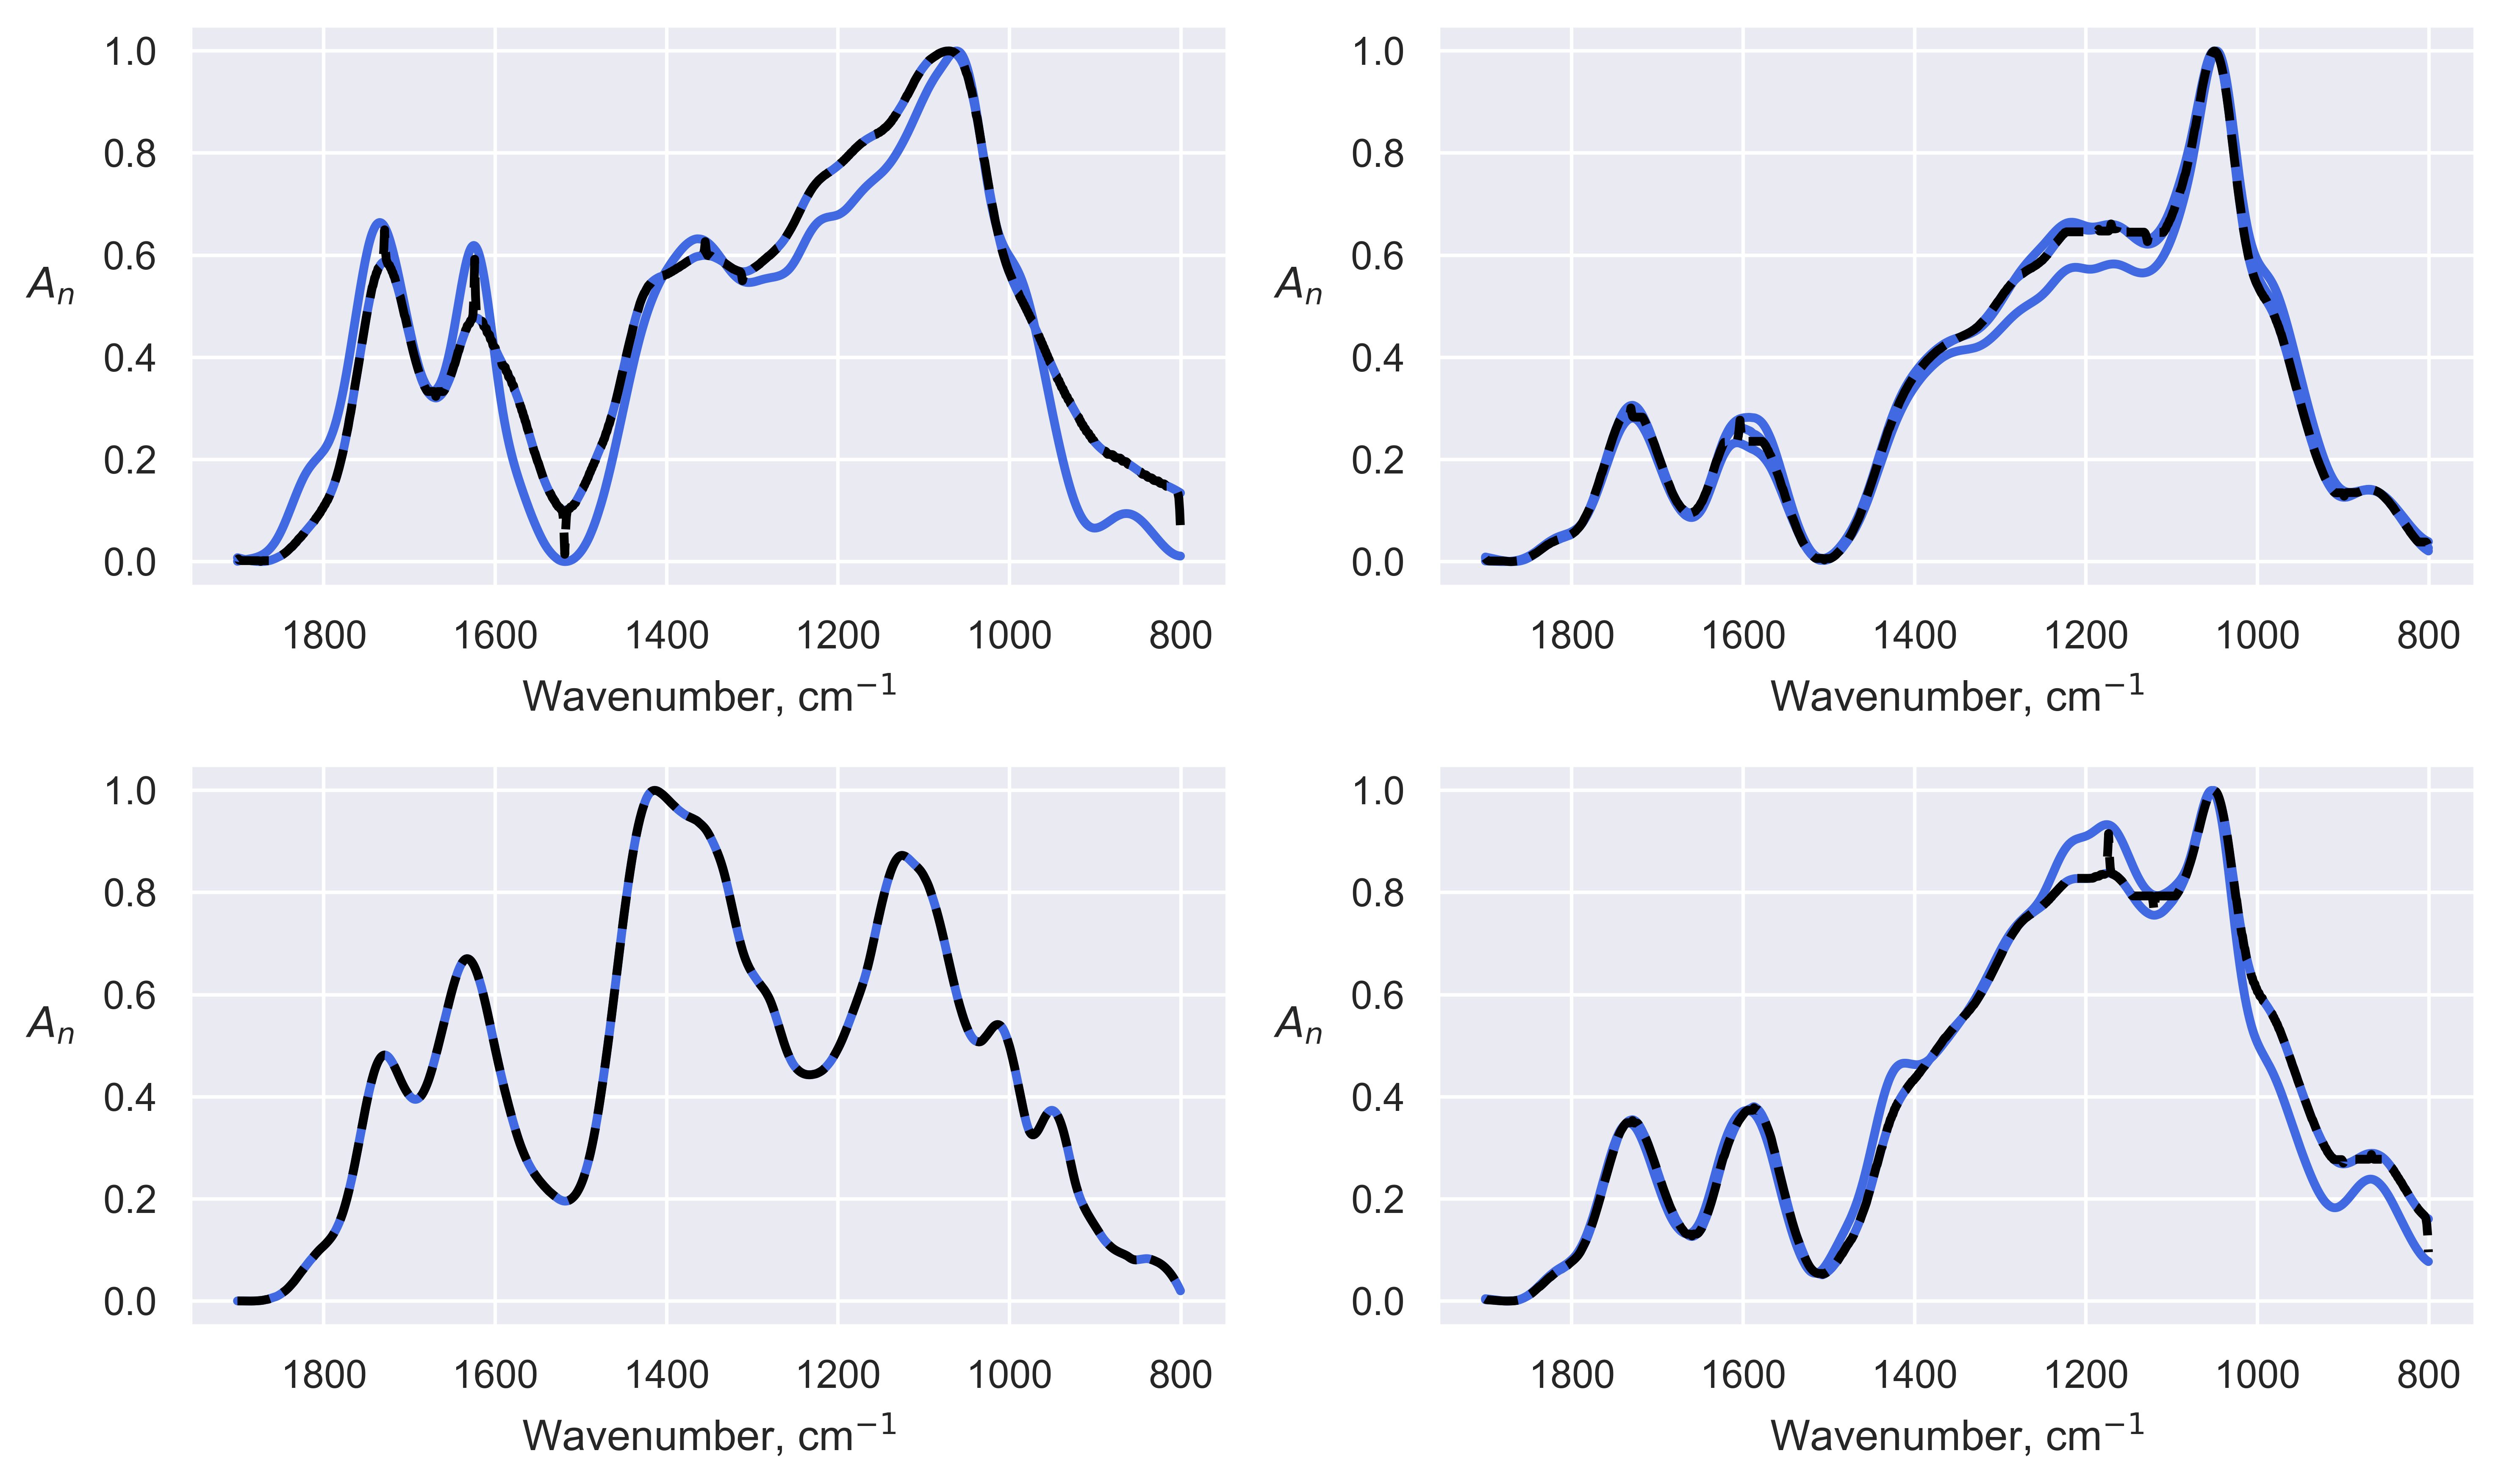

In [19]:
analyzer.get_spectra_clusters_visualization(data=go_data, wavenumber=wavenumber, n_clusters=4,
                                            ncols=2, nrows=2, figsize=(10, 6), color='RoyalBlue',
                                            path_to_save=path_to_save + '/go_clusters.png', dpi=600)

### *rGO*

Computing silhouette values: 100%|████████████████| 1/1 [00:01<00:00,  1.49s/it]


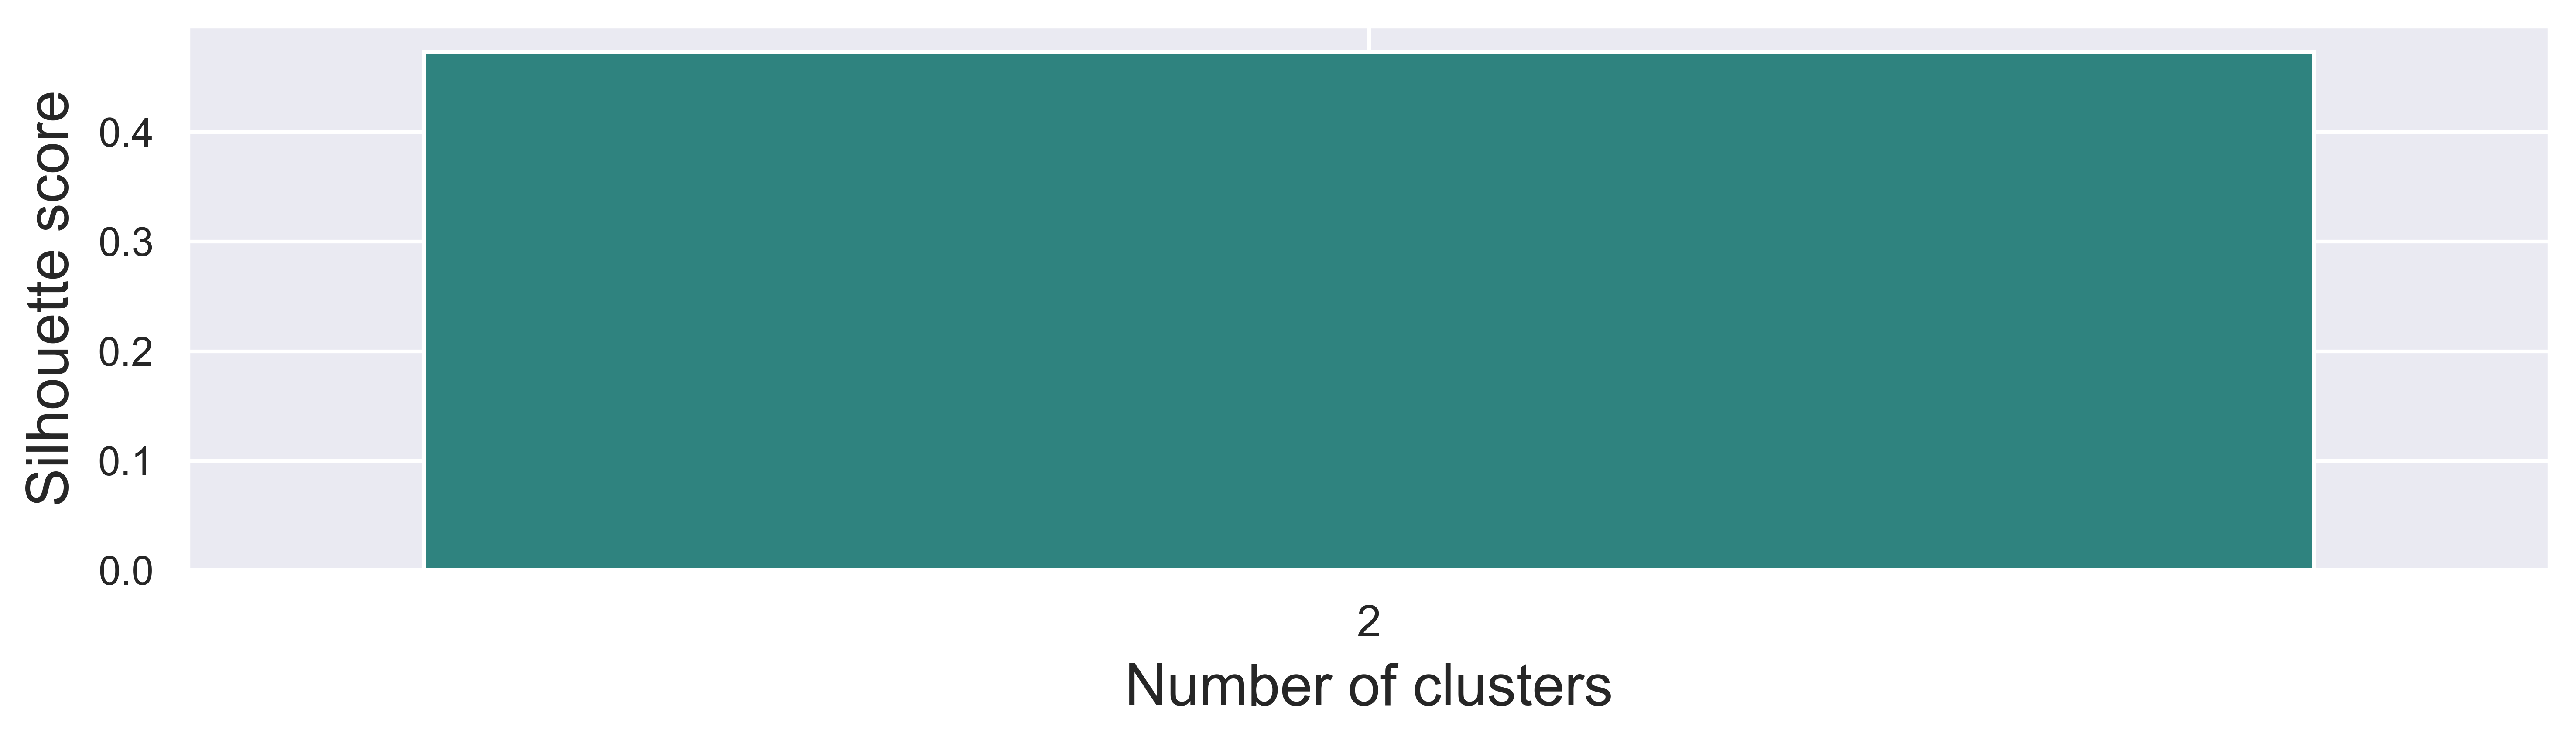

In [20]:
analyzer = ClusterStructureAnalysis(metric='dtw')
analyzer.fit_transform_ts_kmeans(train_data=rgo_data, n_clusters=2)

analyzer.get_metrics_visualization(metric='silhouette', figsize=(10, 3), path_to_save=path_to_save + '/rgo_metrics.png', dpi=600)

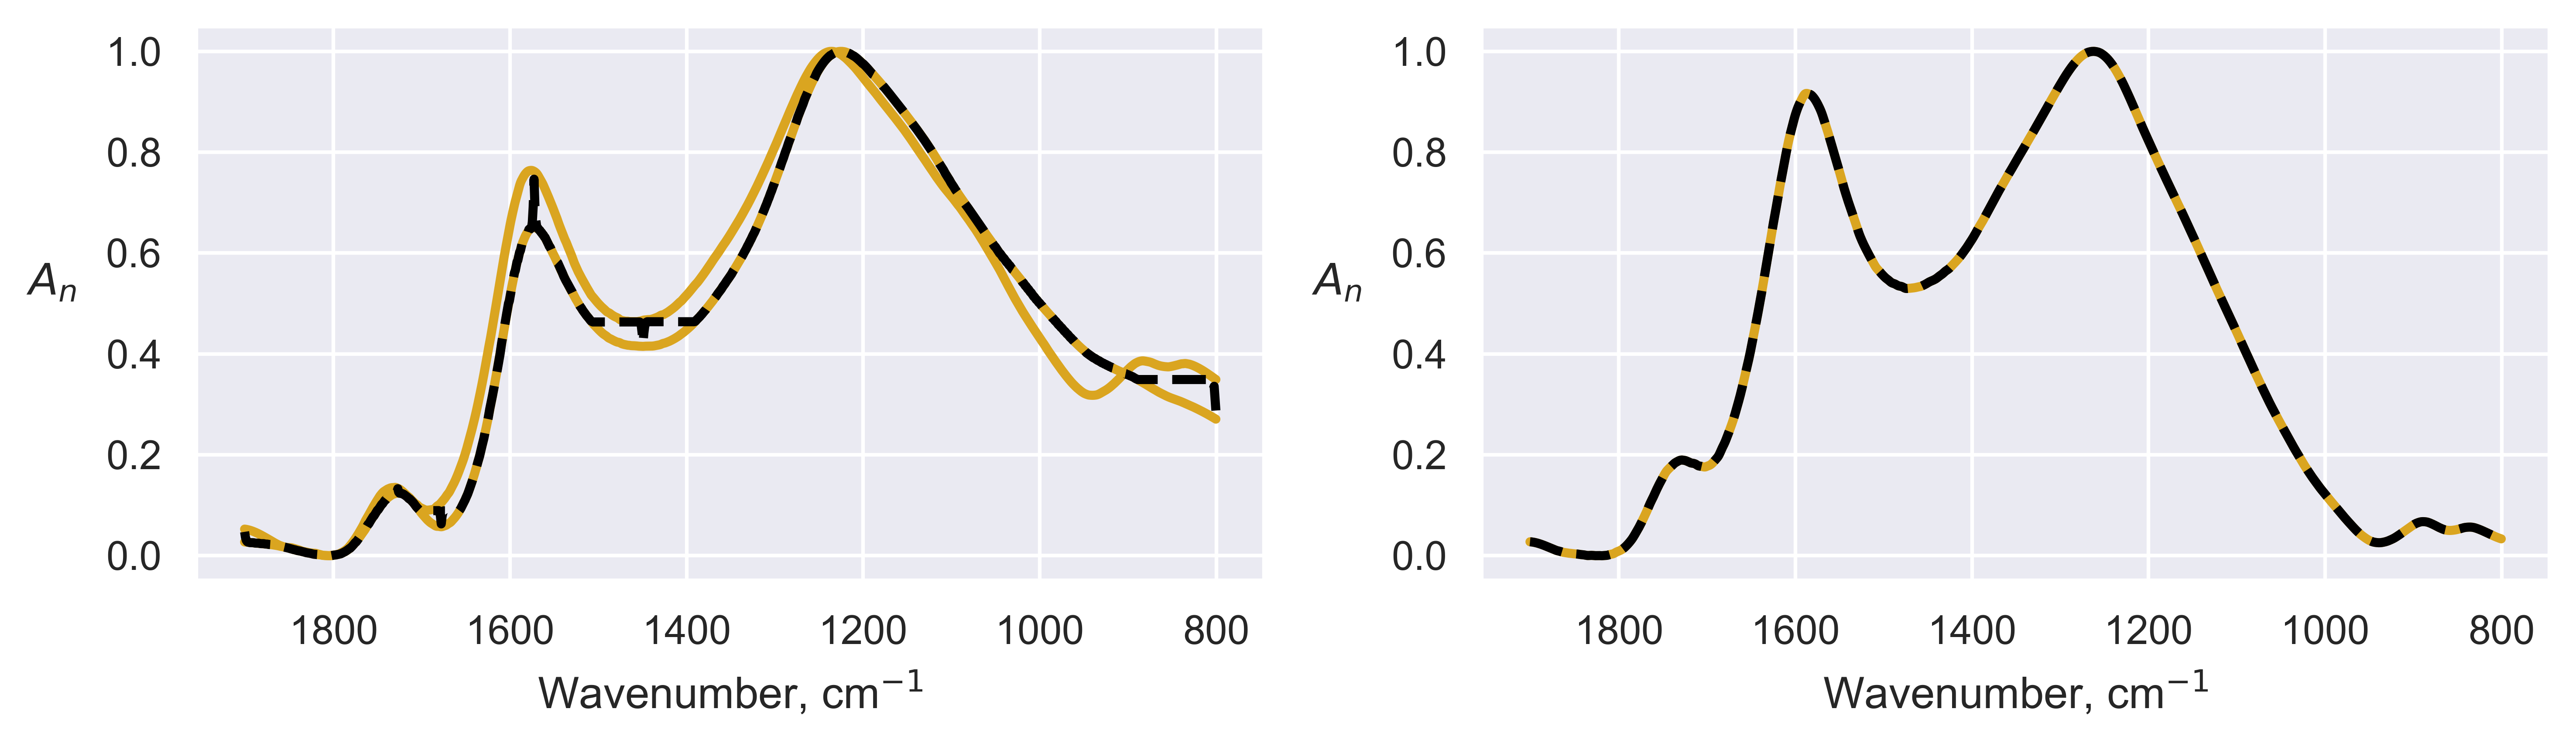

In [21]:
analyzer.get_spectra_clusters_visualization(data=rgo_data, wavenumber=wavenumber, n_clusters=2,
                                            ncols=2, nrows=1, figsize=(10, 3), color='Goldenrod',
                                            path_to_save=path_to_save + '/rgo_clusters.png', dpi=600)

### $GO_{d}$

Computing silhouette values: 100%|██████████████| 12/12 [03:48<00:00, 19.05s/it]


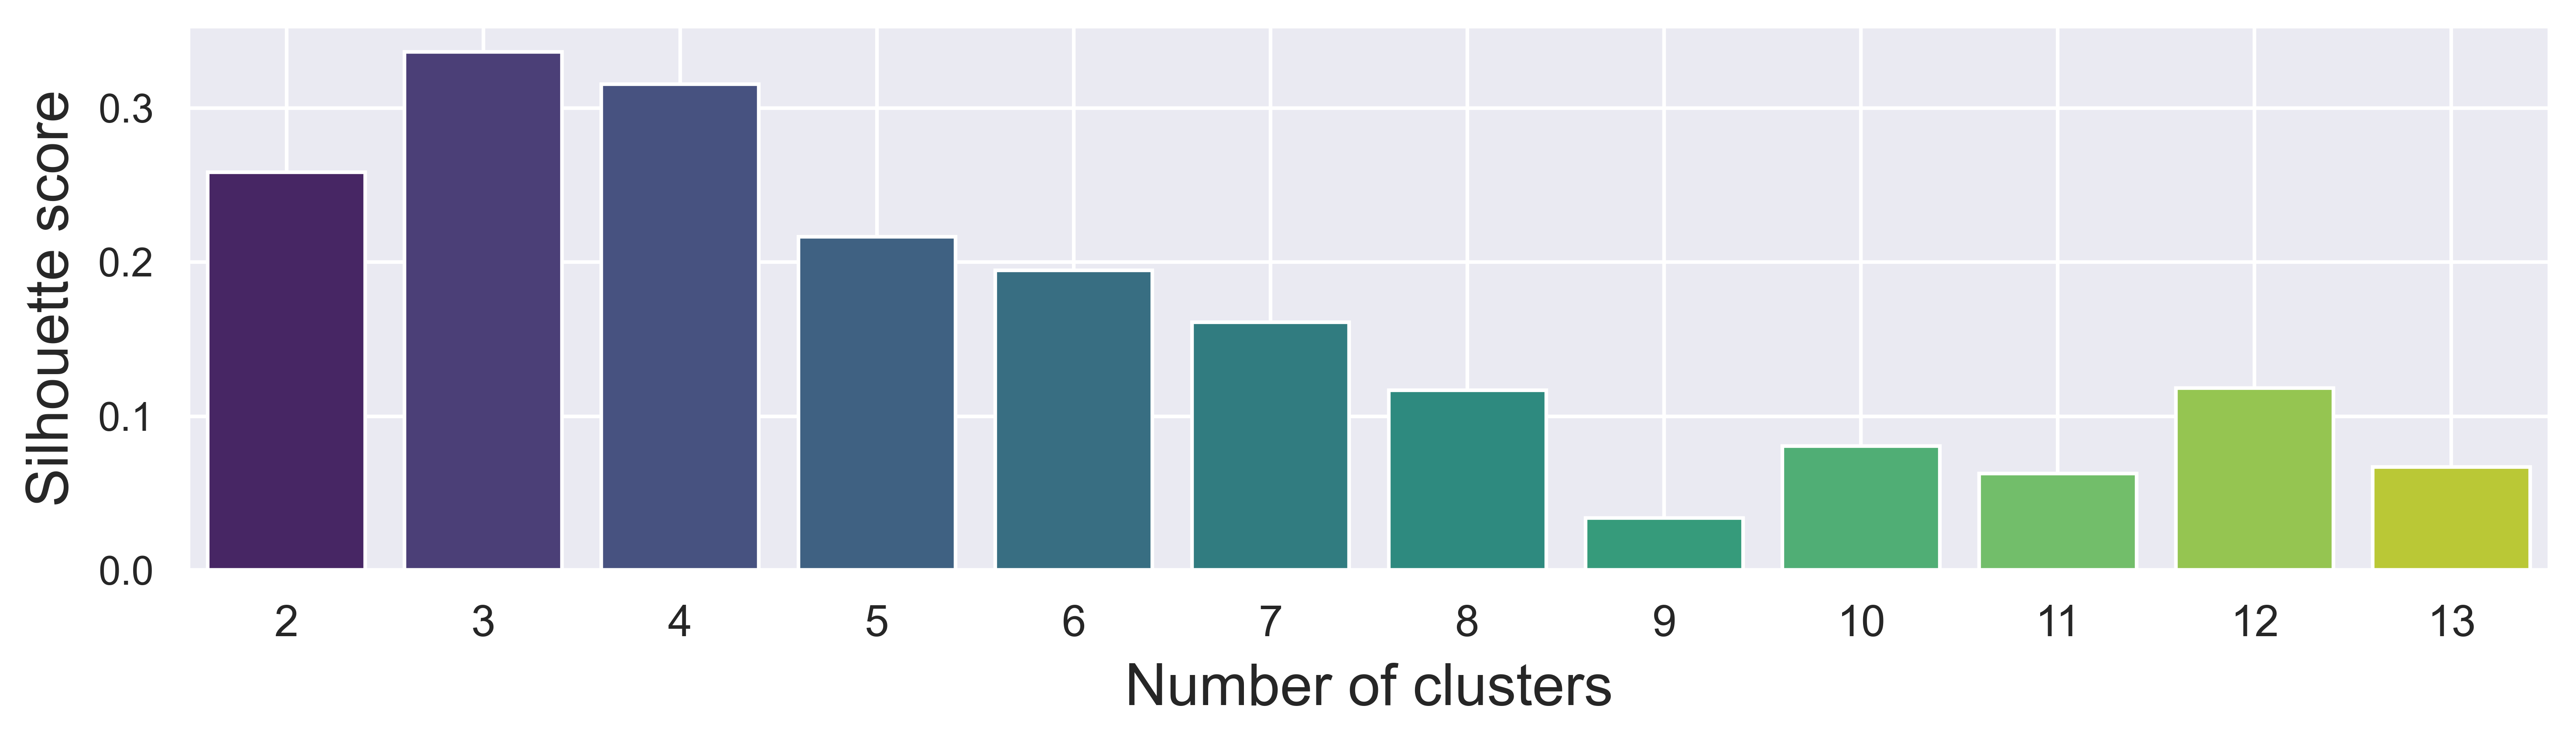

In [22]:
analyzer = ClusterStructureAnalysis(metric='dtw')
analyzer.fit_transform_ts_kmeans(train_data=god_data, n_clusters=2)

analyzer.get_metrics_visualization(metric='silhouette', figsize=(10, 3), path_to_save=path_to_save + '/god_metrics.png', dpi=600)

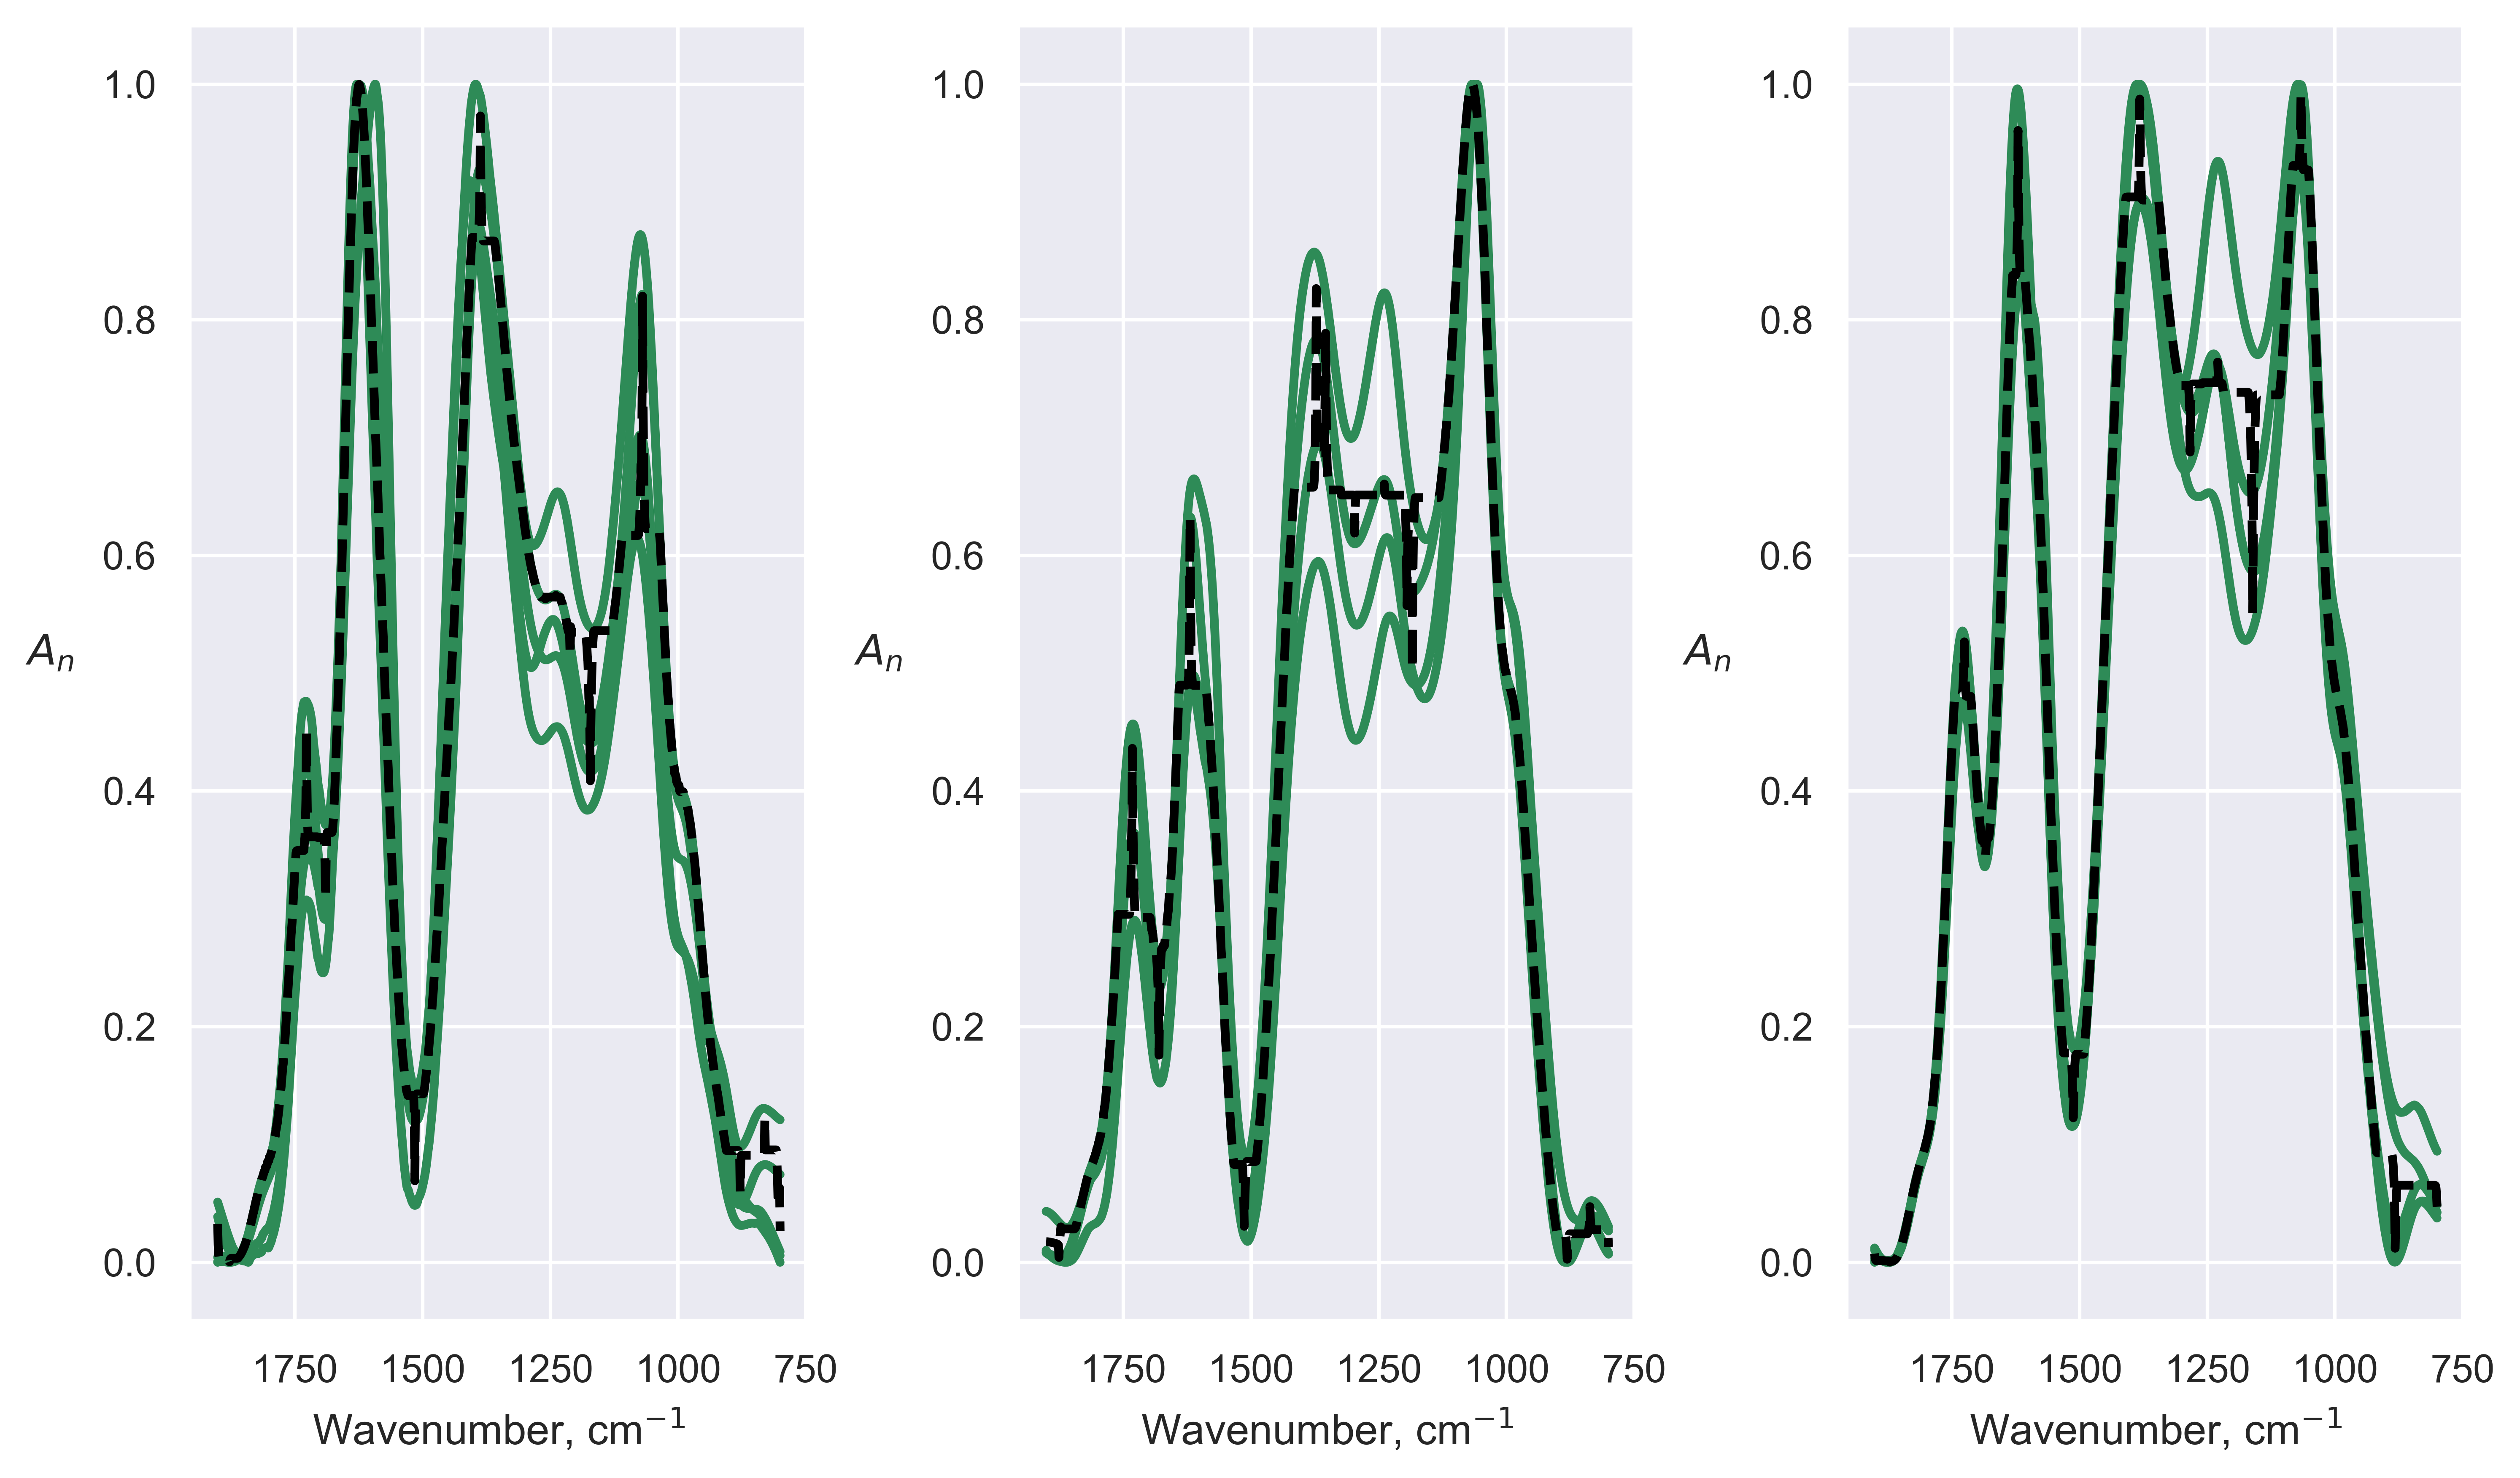

In [23]:
analyzer.get_spectra_clusters_visualization(data=god_data, wavenumber=wavenumber, n_clusters=3,
                                            ncols=3, nrows=1, figsize=(10, 6), color='SeaGreen',
                                            path_to_save=path_to_save + '/god_clusters_3.png', dpi=600
                                           )